# 1. Setup & Library Installation

In [3]:
# 1. Install Library Tambahan
# !pip install Sastrawi
# !pip install imbalanced-learn

# 2. Import Library Utama
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Library Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# 2. Exploratory Data Analysis

=== Sampel Data ===
                                               tweet sentiment
0  @jokowi saya sangat setuju pak bahkan lebih se...  positive
1  @hnurwahid @FPKSDPRRI Saya setuju ibu kota pin...  positive
2  @MardaniAliSera @FPKSDPRRI Saya dan mayoritas ...  positive
3  cocok ibu kota pindah ke kalimantan apalagi gu...  positive
4  @geedeulbeyou1 Jadi kepada lo yang gak setuju ...  positive

=== Distribusi Sentimen ===
Jumlah per Sentimen:
sentiment
positive    1029
negative     435
Name: count, dtype: int64

Persentase per Sentimen:
sentiment
positive    70.29
negative    29.71
Name: proportion, dtype: float64


C:\Users\advan\AppData\Local\Temp\ipykernel_14744\2787028148.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


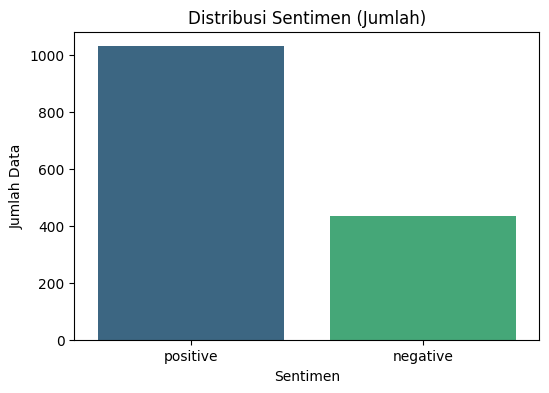

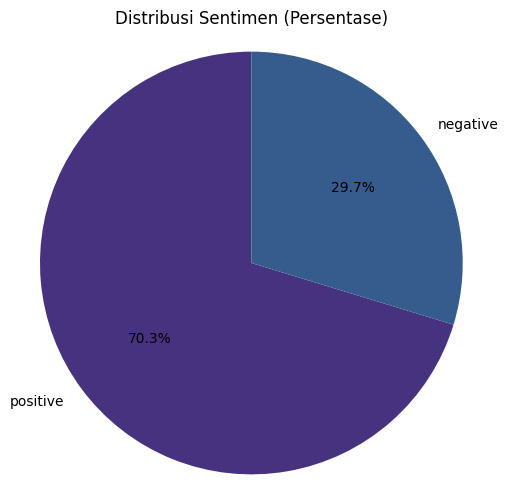


Jumlah Data Kosong: tweet        0
sentiment    0
dtype: int64


In [4]:
# Load Dataset
df = pd.read_csv('ikn.csv')

# Cek 5 data teratas
print("=== Sampel Data ===")
print(df.head())

# Cek distribusi label (Positif vs Negatif)
print("\n=== Distribusi Sentimen ===")
counts = df['sentiment'].value_counts()
percentages = df['sentiment'].value_counts(normalize=True) * 100
print("Jumlah per Sentimen:")
print(counts)
print("\nPersentase per Sentimen:")
print(percentages.round(2))

# Plot Count (Jumlah)
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribusi Sentimen (Jumlah)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Data')
plt.show()

# Plot Pie Chart (Persentase)
plt.figure(figsize=(6,6))
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Distribusi Sentimen (Persentase)')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Cek apakah ada data kosong
print(f"\nJumlah Data Kosong: {df.isnull().sum()}")
df = df.dropna() # Hapus data kosong jika ada

# 3. Data Preprocessing

In [5]:
# Inisialisasi Stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Daftar stopword sederhana (bisa ditambah)
stopwords_id = set(['yang', 'di', 'ke', 'dari', 'pada', 'ini', 'itu', 'adalah', 'untuk', 'dan', 'atau', 'dengan'])

def preprocessing_text(text):
    # 1. Case Folding
    text = text.lower()

    # 2. Cleaning (Hapus URL, Mention, Hashtag, Angka, Tanda Baca)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # 3. Stopword Removal & Tokenization manual
    words = text.split()
    words = [w for w in words if w not in stopwords_id]

    # 4. Stemming
    words = [stemmer.stem(w) for w in words]

    return " ".join(words)

# Terapkan ke dataset
print("Sedang melakukan preprocessing... (bisa memakan waktu)")
df['text_clean'] = df['tweet'].apply(preprocessing_text) # Fixed: Changed 'text' to 'tweet'
print("Preprocessing Selesai!")

Sedang melakukan preprocessing... (bisa memakan waktu)
Preprocessing Selesai!


# 4. Feature Extraction & Splitting Data

In [6]:
# 1. Ubah teks ke angka dengan TF-IDF
tfidf = TfidfVectorizer(max_features=2000) # Ambil 2000 kata terpenting
X = tfidf.fit_transform(df['text_clean']).toarray()
y = df['sentiment']

# 2. Split Data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Training: {X_train.shape}")
print(f"Data Testing: {X_test.shape}")

Data Training: (1171, 2000)
Data Testing: (293, 2000)


# 5. Handling Imbalance

In [7]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribusi Sebelum SMOTE:", pd.Series(y_train).value_counts())
print("Distribusi Setelah SMOTE:", pd.Series(y_train_resampled).value_counts())

Distribusi Sebelum SMOTE: sentiment
positive    820
negative    351
Name: count, dtype: int64
Distribusi Setelah SMOTE: sentiment
positive    820
negative    820
Name: count, dtype: int64


# 6. Training Model

In [8]:
# --- Model 1: Support Vector Machine (SVM) ---
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test)

# --- Model 2: Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)

print("Training Selesai!")

Training Selesai!


# 7. Evaluation

In [9]:
print("=== HASIL EVALUASI SVM ===")
print(classification_report(y_test, y_pred_svm))
print("Akurasi SVM:", accuracy_score(y_test, y_pred_svm))

print("\n" + "="*50 + "\n")

print("=== HASIL EVALUASI RANDOM FOREST ===")
print(classification_report(y_test, y_pred_rf))
print("Akurasi RF:", accuracy_score(y_test, y_pred_rf))

=== HASIL EVALUASI SVM ===
              precision    recall  f1-score   support

    negative       0.77      0.87      0.82        84
    positive       0.94      0.89      0.92       209

    accuracy                           0.89       293
   macro avg       0.86      0.88      0.87       293
weighted avg       0.89      0.89      0.89       293

Akurasi SVM: 0.8873720136518771


=== HASIL EVALUASI RANDOM FOREST ===
              precision    recall  f1-score   support

    negative       0.73      0.76      0.74        84
    positive       0.90      0.89      0.89       209

    accuracy                           0.85       293
   macro avg       0.81      0.82      0.82       293
weighted avg       0.85      0.85      0.85       293

Akurasi RF: 0.8498293515358362


# 8. Prediksi Kalimat positif dan negatif

In [10]:
def prediksi_sentimen(kalimat):
    # Bersihkan kalimat input
    clean = preprocessing_text(kalimat)
    # Ubah ke vektor TF-IDF
    vec = tfidf.transform([clean]).toarray()
    # Prediksi (Pilih model terbaik, misal SVM)
    pred = svm_model.predict(vec)
    return pred[0]

# Tes kalimat bebas
contoh1 = "Saya mendukung IKN untuk pemerataan pembangunan"
contoh2 = "Saya menolak IKN agar ekonomi"

print(f"Kalimat 1: {contoh1} -> {prediksi_sentimen(contoh1)}")
print(f"Kalimat 2: {contoh2} -> {prediksi_sentimen(contoh2)}")

Kalimat 1: Saya mendukung IKN untuk pemerataan pembangunan -> positive
Kalimat 2: Saya menolak IKN agar ekonomi -> negative


# 9. Analisis kata populer berdasarkan sentimen

=== 10 Kata Kunci Paling Berpengaruh dalam Opini IKN ===
           kata  importance
1896      tolak    0.056673
1422  nusantara    0.039875
488         ikn    0.038288
274      dukung    0.033864
1625     pindah    0.031205
473         ibu    0.027716
1980      xexxa    0.023790
1989         yg    0.021802
918        kota    0.020224
1882      timur    0.016630

Analisis Kata Terpopuler Berdasarkan Sentimen:


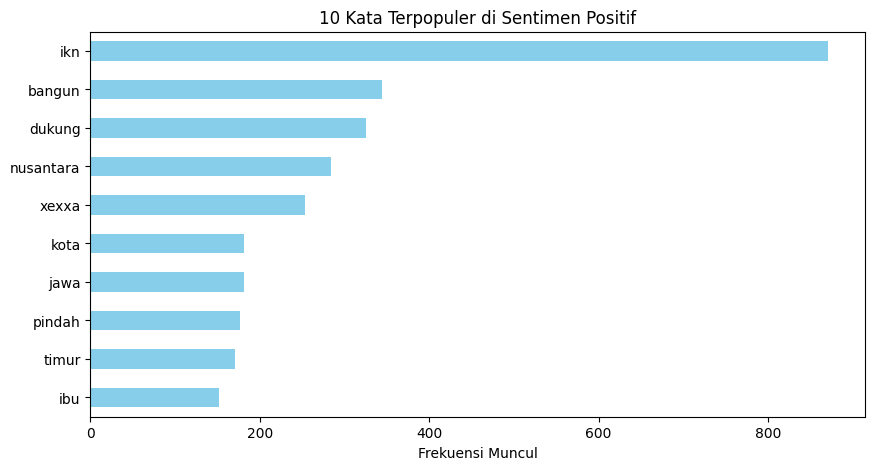

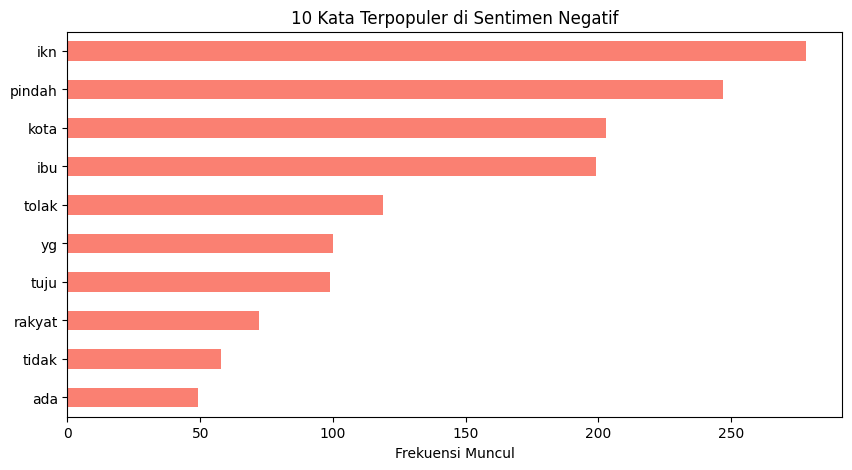

In [11]:
# 1. Ambil nama fitur (kata-kata) dari TF-IDF
feature_names = tfidf.get_feature_names_out()

# 2. Ambil tingkat kepentingan kata dari Random Forest
# Pastikan rf_model sudah dilatih, jika belum, jalankan sel Training Model terlebih dahulu.
importances = rf_model.feature_importances_

# 3. Gabungkan kata dengan skor kepentingannya
feature_importance_df = pd.DataFrame({'kata': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 4. Tampilkan 10 Kata Kunci Utama yang Mempengaruhi Sentimen
print("=== 10 Kata Kunci Paling Berpengaruh dalam Opini IKN ===")
print(feature_importance_df.head(10))

# 5. Fungsi untuk mengambil kata terpopuler berdasarkan sentimen (untuk plot)
def plot_top_words(label_target, title, color, n=10):
    # Filter teks berdasarkan sentiment dari dataset asli
    text_subset = df[df['sentiment'] == label_target]['text_clean']

    # Hitung frekuensi kata
    word_freq = pd.Series(' '.join(text_subset).split()).value_counts()

    # Ambil n kata teratas
    top_words = word_freq.head(n)

    # Plotting
    plt.figure(figsize=(10, 5))
    top_words.plot(kind='barh', color=color)
    plt.title(title)
    plt.gca().invert_yaxis() # Supaya kata teratas ada di paling atas
    plt.xlabel('Frekuensi Muncul')
    plt.show()

# 6. Jalankan Visualisasi Kata Terpopuler per Sentimen
print("\nAnalisis Kata Terpopuler Berdasarkan Sentimen:")
plot_top_words('positive', '10 Kata Terpopuler di Sentimen Positif', 'skyblue')
plot_top_words('negative', '10 Kata Terpopuler di Sentimen Negatif', 'salmon')


# 10. Analisis tema berdasarkan sentimen

MEMPROSES ANALISIS SENTIMEN DAN TOPIK...

=== Rincian Alasan MENDUKUNG IKN ===
Pemerataan Pembangunan: 37.80%
Infrastruktur & Visi Modern: 12.24%
Ekonomi & Anggaran: 8.84%
Tata Kelola & Kenegaraan: 3.40%
Kesejahteraan Masyarakat: 1.85%
Lingkungan & Alam: 0.49%


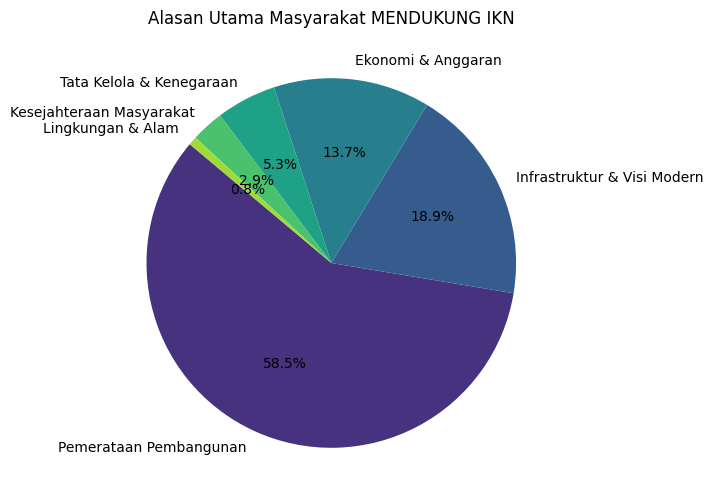


=== Rincian Alasan MENOLAK IKN ===
Ekonomi & Anggaran: 14.25%
Pemerataan Pembangunan: 12.41%
Kesejahteraan Masyarakat: 10.11%
Tata Kelola & Kenegaraan: 8.97%
Infrastruktur & Visi Modern: 4.60%
Lingkungan & Alam: 2.76%
Kritik Politik & Oligarki: 1.84%


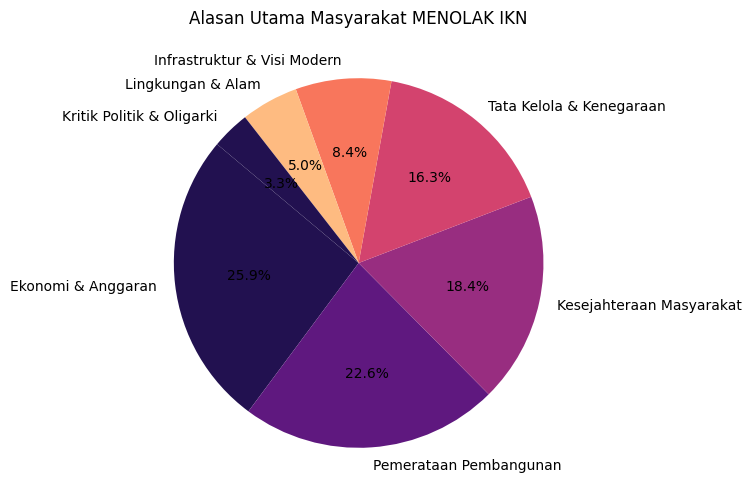

In [12]:
kamus_topik = {
    'Ekonomi & Anggaran': [
        'biaya', 'anggaran', 'mahal', 'utang', 'pajak', 'uang', 'dana', 'ekonomi', 'subsidi', 'mencekik'
    ],
    'Pemerataan Pembangunan': [
        'jawa', 'sentris', 'pemerataan', 'daerah', 'luar', 'pelosok', 'bangun', 'adil', 'sejahtera'
    ],
    'Lingkungan & Alam': [
        'hutan', 'pohon', 'lingkungan', 'satwa', 'rusak', 'alam', 'paru', 'borneo', 'iklim', 'ekologi'
    ],
    'Infrastruktur & Visi Modern': [
        'gedung', 'istana', 'jalan', 'transportasi', 'fasilitas', 'modern', 'smart', 'teknologi', 'digital', 'konsep', 'maju'
    ],
    'Tata Kelola & Kenegaraan': [
        'pemerintah', 'presiden', 'negara', 'kebijakan', 'asn', 'ibukota', 'nasional'
    ],
    'Kesejahteraan Masyarakat': [
        'rakyat', 'masyarakat', 'warga', 'sosial', 'umat'
    ],
    'Kritik Politik & Oligarki': [
        'oligarki', 'kepentingan', 'janji', 'elit', 'pejabat', 'penguasa', 'politik'
    ]
}

def kelompokkan_topik(text):
    text = text.lower()
    for topik, keywords in kamus_topik.items():
        for word in keywords:
            # Menggunakan regex \b agar tidak salah deteksi (misal: 'elit' di 'belitung')
            if re.search(r'\b' + word + r'\b', text):
                return topik
    return 'Lain-lain'

# 1. Terapkan kategori topik ke dataset
df['topik'] = df['text_clean'].apply(kelompokkan_topik)

# 2. Fungsi Visualisasi
def visualisasi_analisis_opini(sentiment_target, judul, skema_warna):
    # Filter data berdasarkan sentimen
    df_filtered = df[df['sentiment'] == sentiment_target]

    # Hitung distribusi topik
    counts = df_filtered['topik'].value_counts(normalize=True) * 100

    # KUNCI: Hapus kategori negatif dari visualisasi POSITIF jika ingin benar-benar bersih
    if sentiment_target == 'positive':
        counts = counts.drop(['Kritik Politik & Oligarki', 'Lain-lain'], errors='ignore')
    else:
        counts = counts.drop('Lain-lain', errors='ignore')

    print(f"\n=== Rincian Alasan {judul} ===")
    if counts.empty:
        print("Tidak ada data yang cocok dengan kamus topik.")
        return

    for topik, persen in counts.items():
        print(f"{topik}: {persen:.2f}%")

    # Plotting Pie Chart
    plt.figure(figsize=(8, 6))
    counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette(skema_warna))
    plt.title(f'Alasan Utama Masyarakat {judul}')
    plt.ylabel('')
    plt.show()

# 3. Eksekusi
print("MEMPROSES ANALISIS SENTIMEN DAN TOPIK...")
visualisasi_analisis_opini('positive', 'MENDUKUNG IKN', 'viridis')
visualisasi_analisis_opini('negative', 'MENOLAK IKN', 'magma')

# Import model

In [13]:
import joblib

# Simpan model dan vectorizer TF-IDF
joblib.dump(svm_model, 'model_svm_ikn.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']